# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [132]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Load Data

In [133]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])

## Feature Engineering for Training Data

In [134]:
# first need previous matchups (1998 - 2017)
df_matchups = pd.DataFrame(
    { 'Team1' : df_tour_compact['WTeamID'],
     'Team2' : df_tour_compact['LTeamID'],
     'Outcome': map(int, df_tour_compact['WScore'] > df_tour_compact['LScore']),
     'Season' : df_tour_compact['Season']
    })

df_matchups.tail()

,Outcome,Season,Team1,Team2
1255,1,2017,3163,3332
1256,1,2017,3376,3199
1257,1,2017,3280,3163
1258,1,2017,3376,3390
1259,1,2017,3376,3280


### Current Year Seeds

In [135]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [136]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'Team1', 'SeedInt':'Team1Seed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2', 'SeedInt':'Team2Seed'})
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

df_matchups.tail()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed
1255,1,2017,3163,3332,1,10
1256,1,2017,3376,3199,1,3
1257,1,2017,3280,3163,2,1
1258,1,2017,3376,3390,1,2
1259,1,2017,3376,3280,1,2


### Current Year Seed Difference

In [137]:
# negative number indicates that team 2 (loser, in this case) has higher seed
df_matchups['SeedDiff'] = df_matchups['Team2Seed']
df_matchups['SeedDiff'] = df_matchups['Team2Seed'].sub(df_matchups['Team1Seed'], axis=0)

df_matchups.tail()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff
1255,1,2017,3163,3332,1,10,9
1256,1,2017,3376,3199,1,3,2
1257,1,2017,3280,3163,2,1,-1
1258,1,2017,3376,3390,1,2,1
1259,1,2017,3376,3280,1,2,1


### Last Year's Tournament Seed 

In [138]:
# what to do for games where we had no previous year (1998)?

# add 1 so easily referenced
df_seeds['Season'] = df_seeds['Season'].apply(lambda x: x + 1)

In [139]:
df_W = df_seeds.rename(columns={'TeamID':'Team1','SeedInt':'Team1PrevSeed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2','SeedInt':'Team2PrevSeed'})
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

## what to do if they weren't in the tournament last year (17?)

df_matchups.head()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
0,1,1998,3104,3422,2,15,13,NaN,NaN
1,1,1998,3112,3365,3,14,11,NaN,NaN
2,1,1998,3163,3193,2,15,13,NaN,NaN
3,1,1998,3198,3266,7,10,3,NaN,NaN
4,1,1998,3203,3208,10,7,-3,NaN,NaN


### Average Tournament Seed Over Past 5 Years - TODO

### Last Year's Tournament Performance 

### Average Tournament Performance Over Past 5 Years

### League Competitiveness

In [140]:
df_tour_hist = df_matchups
df_tour_hist.head()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
0,1,1998,3104,3422,2,15,13,NaN,NaN
1,1,1998,3112,3365,3,14,11,NaN,NaN
2,1,1998,3163,3193,2,15,13,NaN,NaN
3,1,1998,3198,3266,7,10,3,NaN,NaN
4,1,1998,3203,3208,10,7,-3,NaN,NaN


In [141]:
#
winning_games_w = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'WWins'})
winning_games_l = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'LWins','Team1':'Team2'})

losing_games_w = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'WLosses','Team2':'Team1'})
losing_games_l = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'LLosses'})

# get total tournament games - all games, could be more than 1 appearance per year
df_total_apps = pd.merge(left=df_tour_hist, right=winning_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=winning_games_l, how='left', on=['Team2']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_l, how='left', on=['Team2']).fillna(0)


df_total_apps['WTotGames'] = df_total_apps['WWins'] + df_total_apps['WLosses']
df_total_apps['WPctWins'] = df_total_apps['WWins'] / df_total_apps['WTotGames'] 

df_total_apps['LTotGames'] = df_total_apps['LWins'] + df_total_apps['LLosses']
df_total_apps['LPctWins'] = df_total_apps['LWins'] / df_total_apps['LTotGames'] 

# This now includes: 
df_total_apps.head()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,WWins,LWins,WLosses,LLosses,WTotGames,WPctWins,LTotGames,LPctWins
0,1,1998,3104,3422,2,15,13,0.0,0.0,3,0.0,2,1,5,0.600000,1.0,0.0
1,1,1998,3112,3365,3,14,11,0.0,0.0,5,0.0,6,4,11,0.454545,4.0,0.0
2,1,1998,3163,3193,2,15,13,0.0,0.0,93,0.0,10,2,103,0.902913,2.0,0.0
3,1,1998,3198,3266,7,10,3,0.0,0.0,2,3.0,3,7,5,0.400000,10.0,0.3
4,1,1998,3203,3208,10,7,-3,0.0,0.0,9,27.0,11,18,20,0.450000,45.0,0.6


In [142]:
# determine 'competitiveness of league' 
## What teams have good win percentages
df_win_apps = df_total_apps.rename(columns={'WPctWins' : 'PctWins','Team1' : 'TeamID', 'WTotGames': 'TotGames'})
df_loss_apps = df_total_apps.rename(columns={'LPctWins' : 'PctWins', 'Team2' : 'TeamID', 'LTotGames': 'TotGames'})

df_apps = df_win_apps[['PctWins','TeamID','TotGames']].append(df_loss_apps[['PctWins','TeamID','TotGames']])
df_apps = df_apps.drop_duplicates()

## This means that a lot of these have never been to the tournament - makes sense
#plt.hist(df_apps['PctWins'],bins=10)

# Maybe need to filter for just teams that are currently in tourney
#l = df_seeds.loc[df_seeds['Season'] == 2018]
#plt.hist((df_apps[df_apps['TeamID'].isin(l['TeamID'])])['PctWins'],bins=10)

In [143]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [147]:
# Merge Performance Stats with league info
df_league_pct = pd.merge(left=df_apps, right = df_teams_leagues, how='left', on=['TeamID'])

# group by league to see how leagues perform
df_league_perf = df_league_pct.groupby('LeagueName')['PctWins'].mean().reset_index()

df_league_perf

LeagueName   PctWins      
                       mean count
0             AAC  0.244191    12
1             ACC  0.546656    14
2            ASUN  0.050000     4
3    America East  0.168571     5
4     Atlantic 10  0.266138     9
5          Big 12  0.538906    10
6        Big East  0.387647     8
7         Big Sky  0.000000     8
8       Big South  0.023529     5
9         Big Ten  0.442750    14
10       Big West  0.044643     7
11          C-USA  0.298990    11
12            CAA  0.114286     5
13        Horizon  0.101010     6
14     Ivy League  0.068571     5
15           MAAC  0.091667     8
16            MAC  0.071429    11
17           MEAC  0.000000     8
18            MVC  0.105769     6
19            MWC  0.173882     7
20            NEC  0.000000     5
21            OVC  0.000000     8
22         Pac-12  0.539678    11
23        Patriot  0.000000     8
24            SEC  0.591840    14
25           SWAC  0.000000     7
26          SoCon  0.011905     6
27      Southland  0.028571     5
28  Summit League  0.044444     5
29       Sun Belt  0.047619     7
30            WAC  0.000000     1
31            WCC  0.152099     8

In [ ]:
df_teams_leagues = pd.merge(left=df_teams_leagues,right = df_league_perf, how='left', on=['LeagueName'])

In [126]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName,PctWins
0,3101,Abilene Chr,Southland,0.028571
1,3102,Air Force,MWC,0.173882
2,3103,Akron,MAC,0.071429
3,3104,Alabama,SEC,0.591840
4,3105,Alabama A&M,SWAC,0.000000


In [127]:
df_W = df_teams_leagues.rename(columns={'TeamID':'Team1','LeagueName':'Team1League', 'PctWins' : "Team1LeaguePerf"})
df_L = df_teams_leagues.rename(columns={'TeamID':'Team2','LeagueName':'Team2League', 'PctWins' : "Team2LeaguePerf"})


In [128]:
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Team2'])

df_matchups.tail()

,Outcome,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,TeamName_x,Team1League,Team1LeaguePerf,TeamName_y,Team2League,Team2LeaguePerf
1255,1,2017,3163,3332,1,10,9,1.0,NaN,Connecticut,AAC,0.244191,Oregon,Pac-12,0.539678
1256,1,2017,3376,3199,1,3,2,1.0,5.0,South Carolina,SEC,0.591840,Florida St,ACC,0.546656
1257,1,2017,3280,3163,2,1,-1,5.0,1.0,Mississippi St,SEC,0.591840,Connecticut,AAC,0.244191
1258,1,2017,3376,3390,1,2,1,1.0,4.0,South Carolina,SEC,0.591840,Stanford,Pac-12,0.539678
1259,1,2017,3376,3280,1,2,1,1.0,5.0,South Carolina,SEC,0.591840,Mississippi St,SEC,0.591840


## FROM BASELINE SUBMISSION - EDIT/REMOVE THIS

In [129]:
# Baseline: just use seed information? 
# Baseline: 50/50 chance? (even easier)

In [26]:
# Stage 1: submission file
# Make predictions for all possible matchups from the past four NCAA® tournaments 2014-2017
# (64*63/2 = 2,016 predictions per year)
recent_tourney_teams = df_seeds = df_seeds[df_seeds['Season'] > 2013]
recent_tourney_teams = recent_tourney_teams.reset_index(drop=True)
recent_tourney_teams.head(10)

# how to match these up pairwise each year??

# ID - string SSSS_XXXX_YYYY, SSSS = 4-digit season yr, 
# XXXX  = 4-digit TeamID of lower-ID team, YYYY = 4-digit TeamID of higher-ID team.
# Pred - predicted winning percentage for the first team in the ID field

,Season,Seed,TeamID
0,2014,W01,3163
1,2014,W02,3181
2,2014,W03,3401
3,2014,W04,3304
4,2014,W05,3301
5,2014,W06,3211
6,2014,W07,3177
7,2014,W08,3208
8,2014,W09,3386
9,2014,W10,3328


In [27]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,13,1
1,11,1
2,13,1
3,3,1
4,-3,1


In [28]:
## Create training and test data sets; may create a dev dataset later
num_test = len(df_predictions)

# TODO: Add dev data!
mask = np.random.rand(len(df_predictions)) < 0.8 ## 80% data for training and 20% for testing
train_data = df_predictions[mask]
test_data = df_predictions[~mask]

#test_data, test_labels = df_predictions.data[num_test/2:], newsgroups_test.target[num_test/2:]
#dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
#train_data, train_labels = newsgroups_train.data, newsgroups_train.target


In [29]:
## Convert to arrays
X_train = train_data.SeedDiff.values.reshape(-1,1)
y_train = train_data.Result.values
X_test = test_data.SeedDiff.values.reshape(-1,1)
y_test = test_data.Result.values

In [30]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4664, with best C: 0.1


Text(0,0.5,u'P(Team1 will win)')

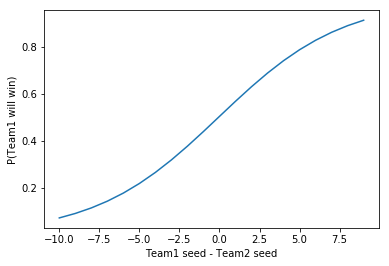

In [31]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [32]:
df_sample_sub = pd.read_csv('WSampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))


In [33]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label


In [34]:
## Unpack the ID field for team IDs
## Look up seeds for the team
## Calculate seed difference

X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed


In [36]:
## Make predictions

preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head(10)

,ID,Pred
0,2014_3103_3107,0.376260
1,2014_3103_3113,0.739968
2,2014_3103_3119,0.502908
3,2014_3103_3124,0.945607
4,2014_3103_3140,0.567136
5,2014_3103_3143,0.826767
6,2014_3103_3151,0.629184
7,2014_3103_3163,0.950000
8,2014_3103_3169,0.317780
9,2014_3103_3173,0.860737


In [38]:
df_sample_sub.to_csv('test-submission.csv', index=False)